# Problem Demonstration

In [1]:
import random
import torch
import numpy as np
from tqdm.auto import trange
from tqdm import tqdm

from scipy.optimize import minimize

from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement
from botorch.test_functions import Hartmann

from botorch.models.transforms import Standardize
from botorch.models.transforms.input import Normalize

from matplotlib import pyplot as plt
plt.style.use('ggplot')

c:\apps\miniconda\envs\takeyourtime\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'botorch'

## Define Some Helper Function

In [6]:
def set_seeds(seed=42):
    """set all library random seeds"""
    seed = int(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def random_sample(num_points, dims, seed=42):
    """generate random points in the domain"""
    set_seeds(seed)
    return torch.rand(num_points, dims, dtype=torch.double)

seeds = np.loadtxt('seeds.txt', delimiter=',', dtype=int)

In [55]:
seeds = np.loadtxt('seeds.txt', delimiter=',', dtype=int)
n_init = 3
n_campaigns = 25
budget = 30-n_init

data = np.zeros((n_campaigns, n_init+budget))

# generate starting data values
HART = Hartmann(dim=6, bounds=[(0,1)]*6 ,negate=True)
X_ = random_sample(n_init, 6)
y_ = torch.tensor([HART(x) for x in X_])[:,None]

for i in (pbar0 := trange(n_campaigns, leave=True, colour="red")):
    set_seeds(seeds[i]) # set the random seed for the campaign
    X = X_.clone()
    y = y_.clone()


    for j in (pbar1 := trange(budget, leave=True)):

        # build the gp model
        gp = SingleTaskGP(
            train_X = X,
            train_Y = y,
            input_transform=Normalize(d=X.shape[-1]), # normalize X values
            outcome_transform=Standardize(m=y.shape[-1]) # standardize y values
        )

        # fit the model by maximizing the log marginal likelihood
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        mll = fit_gpytorch_model(mll)

        bounds = torch.tensor([[0.0]*X.shape[-1], [1.0]*X.shape[-1]])

        X_new, acq_value = optimize_acqf(
            acq_function= UpperConfidenceBound(gp, beta=2),
            bounds=bounds,
            q=1, # how many new points to generate
            num_restarts = 20, # how many times to restart the optimizer
            raw_samples = 200 # how many initial points to sample acqf space from
        )

        X = torch.cat([X, X_new])
        y = torch.cat([y, HART(X=X_new)[:,None]])

        pbar0.set_description(f"Processing Trial {j+1} of Campaign {i+1}")
        pbar1.set_description(f"Campaign {i+1} | Best Value {round(torch.max(y).item(),3)}")


    data[i,:] = y.flatten()

Campaign 1 | Best Value 3.167: 100%|██████████| 25/25 [00:05<00:00,  4.55it/s]t/s]
Campaign 2 | Best Value 3.231: 100%|██████████| 25/25 [00:05<00:00,  4.46it/s],  5.49s/it]
Campaign 3 | Best Value 3.173: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s],  5.56s/it]
Campaign 4 | Best Value 3.169: 100%|██████████| 25/25 [00:05<00:00,  4.78it/s],  5.43s/it]
Campaign 5 | Best Value 3.296: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s],  5.35s/it]
Campaign 6 | Best Value 3.317: 100%|██████████| 25/25 [00:06<00:00,  4.13it/s],  5.37s/it]
Campaign 7 | Best Value 3.296: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s],  5.60s/it]
Campaign 8 | Best Value 3.258: 100%|██████████| 25/25 [00:05<00:00,  4.23it/s],  5.50s/it]
Campaign 9 | Best Value 3.066: 100%|██████████| 25/25 [00:06<00:00,  3.61it/s],  5.63s/it]
Campaign 10 | Best Value 3.32: 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]6,  6.03s/it]
Campaign 11 | Best Value 3.281: 100%|██████████| 25/25 [00:07<00:00,  3.53it/s]0,  6.02s/it]
Camp

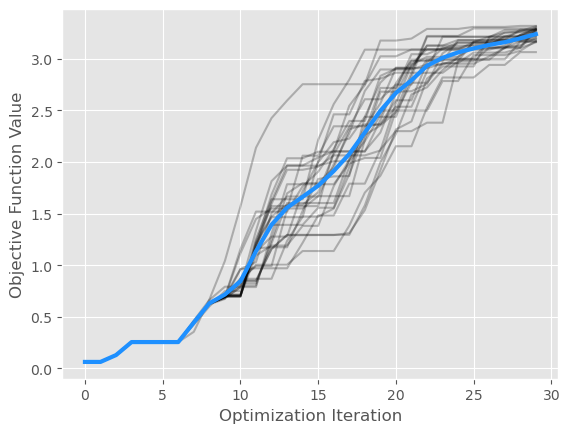

In [56]:
best_to_trial = np.maximum.accumulate(data, axis=1)
best_to_trial_mean = np.mean(best_to_trial, axis=0)
plt.plot(best_to_trial.T, color='black', alpha=0.25, label='trials')
plt.plot(best_to_trial_mean, lw=3, color='dodgerblue', label='mean')
plt.xlabel('Optimization Iteration')
plt.ylabel('Objective Function Value')
plt.show()

## An Example Random Restarts Optimizer

In [23]:
# define a UCB function for the scipy optimizer
def UCB(X, gp, beta=2):
    X = torch.tensor(X)
    mean = gp.posterior(X).mean
    std = gp.posterior(X).stddev
    UCB_val = mean + beta*std
    return -UCB_val.detach().numpy().item()

# build and train a simple model
HART = Hartmann(dim=6, bounds=[(0,1)]*6 ,negate=True)
X_ = random_sample(3, 6)
y_ = torch.tensor([HART(x) for x in X_])[:,None]

gp = SingleTaskGP(
    train_X = X_,
    train_Y = y_,
    input_transform=Normalize(d=X_.shape[-1]), # normalize X values
    outcome_transform=Standardize(m=y_.shape[-1]) # standardize y values
)

# iterate through the seeds and optimize the UCB function
vals = []
xs = []
for i in trange(10):
    set_seeds(seeds[i])
    res = minimize(
        UCB,
        method='L-BFGS-B',
        x0=random_sample(1, 6, seeds[i]).numpy().flatten(),
        args=(gp, 2),
        bounds=[(0,1)]*6,
        options={'maxiter': 1000, 'maxfun': 1000, 'ftol': 1e-20, 'gtol':1e-20, 'maxls':100}
    )
    vals.append(abs(res.fun))
    xs.append(res.x)


print("scipy_opt", gp.posterior(torch.tensor(res.x)).mean)
print("true_opt", HART(torch.tensor(res.x)))

100%|██████████| 10/10 [00:01<00:00,  6.66it/s]

scipy_opt tensor([[0.2277]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
true_opt tensor(0.0478, dtype=torch.float64)


In [24]:
xs

[array([0.        , 0.        , 0.11418725, 0.        , 0.76052215,
        0.50135238]),
 array([0.        , 0.        , 0.1141874 , 0.        , 0.76052213,
        0.50135253]),
 array([0.        , 0.        , 0.11418725, 0.        , 0.76052217,
        0.50135221]),
 array([0.        , 0.        , 0.11418724, 0.        , 0.76052215,
        0.50135234]),
 array([0.        , 0.        , 0.11418739, 0.        , 0.76052219,
        0.50135218]),
 array([0.        , 0.        , 0.11418717, 0.        , 0.76052218,
        0.50135222]),
 array([0.        , 0.        , 0.11418718, 0.        , 0.76052216,
        0.5013524 ]),
 array([0.        , 0.        , 0.1141874 , 0.        , 0.76052218,
        0.50135226]),
 array([0.        , 0.        , 0.11418707, 0.        , 0.76052216,
        0.50135224]),
 array([0.        , 0.        , 0.11418722, 0.        , 0.76052217,
        0.50135213])]